In [1]:
import numpy as np
import itertools

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-poster')

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:

from MomentMatching.baseMomentMatch import MomentMatching, UnscentedTransform, TaylorTransform, MonteCarloTransform
from MomentMatching.TimeSeriesModel import TimeSeriesModel, UniformNonlinearGrowthModel
from MomentMatching.StateModels import GaussianState
from MomentMatching.ExpectationPropagation import EPNodes, TopEP

In [5]:
np.random.seed(seed=102)

In [6]:
N = 100
system = UniformNonlinearGrowthModel()
data = system.system_simulation(N)
x_true, x_noisy, y_true, y_noisy = zip(*data)

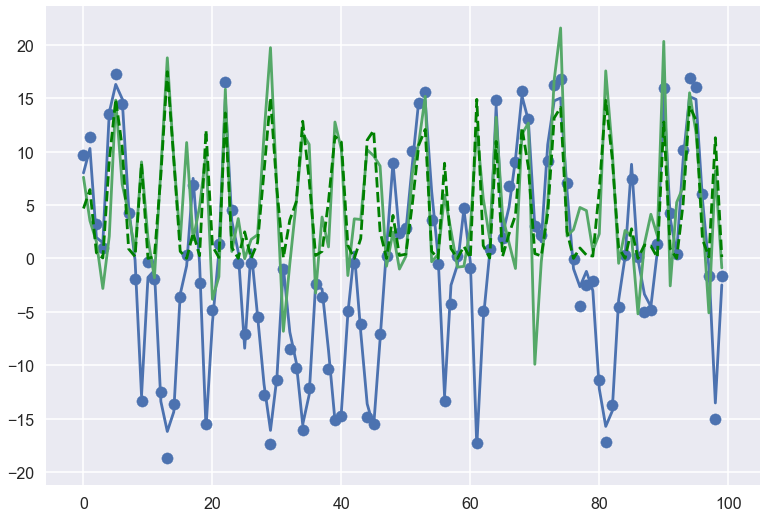

In [7]:
plt.plot(x_true)
plt.scatter(list(range(N)), x_noisy)
plt.plot(y_noisy)
plt.plot(y_true, 'g--')
plt.show()

In [8]:
# transform = TaylorTransform(dimension_of_state=1)
transform = UnscentedTransform(n=1)
# transform = MonteCarloTransform(dimension_of_state=1)
Nodes = EPNodes(dimension_of_state=1, N=N)
EP = TopEP(system_model=system, moment_matching=transform.moment_matching_KF)


In [9]:
prior = Nodes[0].copy()
prior.marginal = system.init_dist

In [10]:
system.init_dist

GaussianState 
 mean=
 [ 0.1], 
 cov=
[[ 1.]])

In [11]:
# EP.forward_update(Nodes[0], prior, 0.0)

In [12]:
def EP_update(self, Nodes, observations, fargs_list):
    prior = Nodes[0].copy()
    prior.marginal = self.system_model.init_dist
        # GaussianState(mean_vec=np.array([0.1]),
        #                            cov_matrix=0.1 * np.eye(1, dtype=float))
    node_iter, next_node_iter = itertools.tee(Nodes)
    next(next_node_iter, None)
    for node, next_node, obs, fargs in itertools.zip_longest(node_iter, next_node_iter, observations, fargs_list):
        pred_state = self.forward_update(node=node, prev_node=prior, fargs=fargs)
        corrected_state = self.measurement_update(pred_state, obs, fargs)
        
        if next_node is not None:
            smoothed_state = self.backward_update(corrected_state, next_node=next_node, fargs=fargs )
        else:
            smoothed_state = corrected_state
            
        yield smoothed_state
        prior = smoothed_state

In [13]:
def kalman_filter(self, Nodes, observations, fargs_list):
    prior = Nodes[0].copy()
    prior.marginal = self.system_model.init_dist
        # GaussianState(mean_vec=np.array([0.1]),
        #                            cov_matrix=0.1 * np.eye(1, dtype=float))

    for node, obs, fargs in zip(Nodes, observations, fargs_list):
        pred_state = self.forward_update(node=node, prev_node=prior, fargs=fargs)
        corrected_state = self.measurement_update(pred_state, obs, fargs)
        yield corrected_state
        prior = corrected_state

        


In [14]:
system.Q.cov

array([[ 1.]])

In [15]:
ans = EP_update(EP, Nodes, y_noisy, range(0, N))

In [16]:
# ans2 = EP_update(EP, Nodes, y_noisy, range(0, N))
# ep_data = list(ans2)

In [17]:
x_filtered = list(ans)
x_filt_mean = [x.marginal.mean for x in x_filtered]

/Users/Pontragyin/Documents/GitHub/pyStateEstimator/MomentMatching/StateModels.py:137: UserWarning: Negative Precision!!!
  warnings.warn('Negative Precision!!!')


[[ 48.28800672]]
[[ 1.90110712]]
[[ 1.11731097]]
[[ 22.18645628]]
[[ 42.85618359]]
[[ 50.53451185]]
[[ 2.7232849]]
[[ 1.22727524]]
[[ 1.65366695]]
[[ 40.11970861]]
[[ 48.17583122]]
[[ 48.40658504]]
[[ 5.4742939]]
[[ 1.14895871]]
[[ 88.1262734]]
[[ 4.45396766]]
[[ 2.7765408]]
[[ 38.11929572]]
[[ 34.56069487]]
[[ 39.840894]]
[[ 1.9133317]]
[[ 2.43923339]]
[[ 31.03196204]]
[[ 3.09968324]]
[[ 74.9215364]]
[[ 61.09556562]]
[[ 35.92400424]]
[[ 50.42921044]]
[[ 3.89854686]]
[[ 4.5216279]]
[[ 62.42246016]]
[[ 48.6093068]]
[[ 55.79067045]]
[[ 5.44068569]]
[[ 1.82625753]]
[[ 71.25433413]]
[[ 2.40870566]]
[[ 14.18352977]]
[[ 29.17921013]]
[[ 37.68633333]]
[[ 2.11619743]]
[[ 1.20891513]]
[[ 1.46846079]]
[[ 55.89490304]]
[[ 36.4540636]]
[[ 32.34442212]]
[[ 1.82558373]]
[[ 1.0226769]]
[[ 88.61006811]]
[[ 45.3253939]]
[[ 24.96463569]]
[[ 5.76598992]]
[[ 1.23131952]]
[[ 61.23516923]]
[[ 46.6725394]]
[[ 47.20353733]]
[[ 23.8723189]]
[[ 50.8516626]]
[[ 49.51195231]]
[[ 3.36277902]]
[[ 1.30425586]]
[[ 66

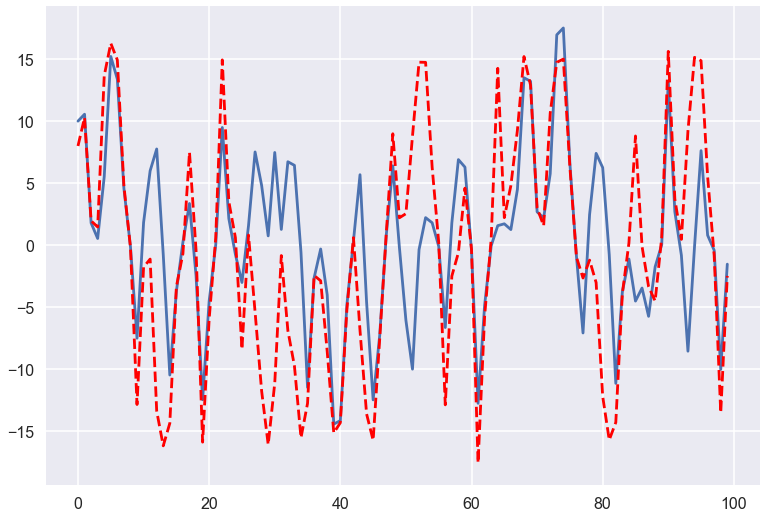

In [18]:
plt.plot(x_filt_mean)
plt.plot(x_true, 'r--', label='x_true')

In [19]:
def plot_gaussian(data):
    x_mean = np.array([x.marginal.mean for x in data])
    x_sigma = np.array([np.sqrt(x.marginal.cov[0, :]) for x in data])
    
    upr = x_mean + 2 * x_sigma
    lwr = x_mean - 2 * x_sigma
#     print(x_mean.shape)
#     print(upr.shape)
#     plt.plot(x_mean)
#     plt.plot(lwr)
#     plt.plot(upr)
#     ax.plt.figure()
    time = np.arange(len(data))
#     time = time[:, np.newaxis]
#     print(time.shape)
    plt.fill_between(time, lwr[:,0], upr[:,0], alpha=0.5)
    
#     print (x1)
#     print(x2)
#     print(x1 + 2 * x2)
#     print(x1 - 2 * x2)

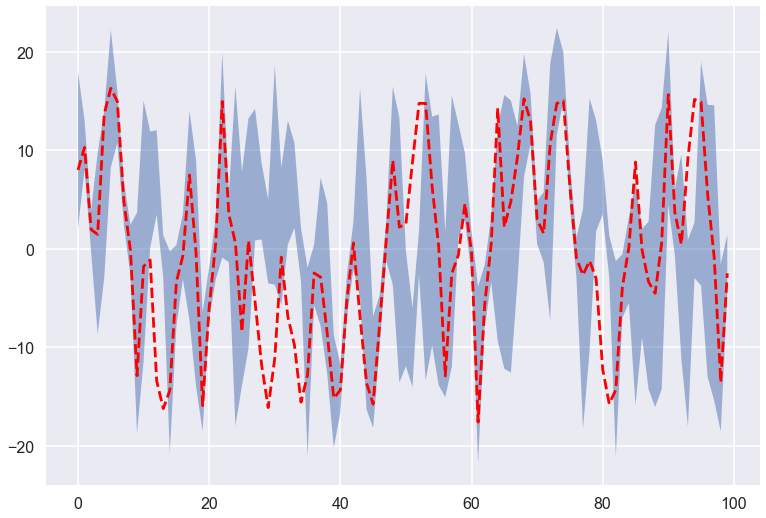

In [20]:
plot_gaussian(x_filtered)
plt.plot(x_true, 'r--', label='x_true')

In [21]:
def kalman_smoother(self, Nodes, fargs_list):
    
    reversedNodes = reversed(Nodes)
    reveresedFargs = reversed(fargs_list)
    
    # Last filtered value is same as first smoothed
    next(reveresedFargs)
    next_node = next(reversedNodes)
    yield next_node
    
    for node, fargs in zip(reversedNodes, reveresedFargs):

        smoothed_node = self.backward_update(node=node, next_node=next_node, fargs=fargs)
#         print(f'node {node.t},  next_node {next_node.t}' )
        yield smoothed_node
        next_node = smoothed_node.copy()
        

In [22]:
sms = kalman_smoother(EP, x_filtered, list(range(0, N)))
x_smoothed = (list(sms))

/Users/Pontragyin/Documents/GitHub/pyStateEstimator/MomentMatching/StateModels.py:137: UserWarning: Negative Precision!!!
  warnings.warn('Negative Precision!!!')


In [23]:

x_smoothed_mean = [x.marginal.mean for x in reversed(x_smoothed)]

In [24]:
[x.marginal.cov for x in reversed(x_smoothed)]

[array([[ 15.68761464]]),
 array([[ 0.87013147]]),
 array([[ 1.61657803]]),
 array([[ 15.66441738]]),
 array([[ 10.93456537]]),
 array([[ 14.2729075]]),
 array([[ 1.5281748]]),
 array([[ 0.27506606]]),
 array([[ 5.48757709]]),
 array([[ 31.30025556]]),
 array([[ 41.11461986]]),
 array([[ 22.45975118]]),
 array([[ 4.57063516]]),
 array([[ 0.82688748]]),
 array([[ 26.1482361]]),
 array([[ 2.00876203]]),
 array([[ 6.60419645]]),
 array([[ 28.24546461]]),
 array([[ 32.91229782]]),
 array([[ 93.06290478]]),
 array([[ 1.82715547]]),
 array([[ 2.43923127]]),
 array([[ 33.12334926]]),
 array([[ 3.05713513]]),
 array([[ 74.09840997]]),
 array([[ 39.80044034]]),
 array([[ 22.37881644]]),
 array([[ 4.45401297]]),
 array([[ 8.50546847]]),
 array([[ 3.52066959]]),
 array([[ 18.02023115]]),
 array([[ 14.692912]]),
 array([[ 34.89416663]]),
 array([[ 4.87684995]]),
 array([[ 1.01482407]]),
 array([[ 7.50168332]]),
 array([[ 4.19639637]]),
 array([[ 10.90141962]]),
 array([[ 10.8170613]]),
 array([[ 8

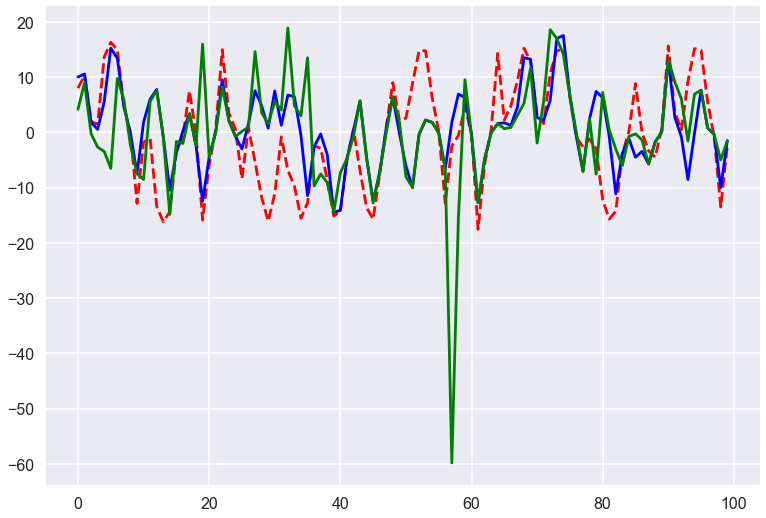

In [25]:
plt.plot(x_true, 'r--', label='x_true')
plt.plot(x_filt_mean, 'b', label='x_filtered')
plt.plot(x_smoothed_mean, 'g', label='x_smoothed')


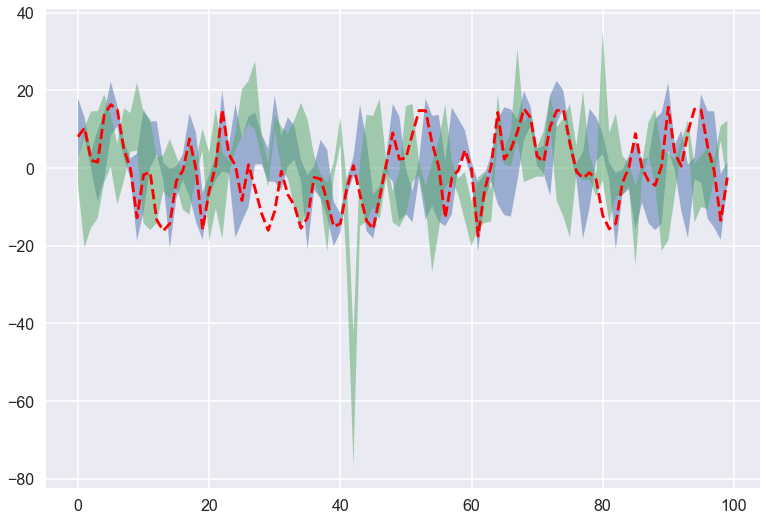

In [26]:
plot_gaussian(x_filtered)
plot_gaussian(x_smoothed)
plt.plot(x_true, 'r--', label='x_true')

In [27]:
data_list = list(reversed(x_smoothed))
for data in data_list:
    print(data.marginal.cov)

[[ 15.68761464]]
[[ 0.87013147]]
[[ 1.61657803]]
[[ 15.66441738]]
[[ 10.93456537]]
[[ 14.2729075]]
[[ 1.5281748]]
[[ 0.27506606]]
[[ 5.48757709]]
[[ 31.30025556]]
[[ 41.11461986]]
[[ 22.45975118]]
[[ 4.57063516]]
[[ 0.82688748]]
[[ 26.1482361]]
[[ 2.00876203]]
[[ 6.60419645]]
[[ 28.24546461]]
[[ 32.91229782]]
[[ 93.06290478]]
[[ 1.82715547]]
[[ 2.43923127]]
[[ 33.12334926]]
[[ 3.05713513]]
[[ 74.09840997]]
[[ 39.80044034]]
[[ 22.37881644]]
[[ 4.45401297]]
[[ 8.50546847]]
[[ 3.52066959]]
[[ 18.02023115]]
[[ 14.692912]]
[[ 34.89416663]]
[[ 4.87684995]]
[[ 1.01482407]]
[[ 7.50168332]]
[[ 4.19639637]]
[[ 10.90141962]]
[[ 10.8170613]]
[[ 8.22287022]]
[[ 9.81704628]]
[[ 1.17381373]]
[[ 1.48208934]]
[[ 28.13538548]]
[[ 34.27273369]]
[[ 49.27046471]]
[[ 1.69289677]]
[[ 0.72251876]]
[[ 25.26028583]]
[[ 48.6229677]]
[[ 13.0457111]]
[[ 4.04783178]]
[[ 1.23116653]]
[[ 60.73062108]]
[[ 33.68728924]]
[[ 47.17048527]]
[[ 17.60607869]]
[[ 71.33946949]]
[[ 33.80900337]]
[[ 3.12875434]]
[[ 0.84324767]]


In [29]:
ans = EP_update(EP, list(reversed(x_smoothed)), y_noisy, range(0, N))
x_filtered2 = list(ans)

[[ 72.97460637]]
[[ 37.94168308]]
[[ 44.97986369]]
2
<class 'MomentMatching.ExpectationPropagation.TimeSeriesNodeForEP'>.(t=2, state_dim=1,
    marginal_init=GaussianState 
 mean=
 [ 6.98101908], 
 cov=
[[-3.93417043]]), factor_init=(GaussianState 
 mean=
 [ 9.53286585], 
 cov=
[[ 322.91259166]]), GaussianState 
 mean=
 [ 6.36108638], 
 cov=
[[-3.57766167]]), GaussianState 
 mean=
 [-1.16849256], 
 cov=
[[ 44.97986369]])))
GaussianState 
 mean=
 [ 7.011735], 
 cov=
[[-3.88681583]])


/Users/Pontragyin/Documents/GitHub/pyStateEstimator/MomentMatching/StateModels.py:137: UserWarning: Negative Precision!!!
  warnings.warn('Negative Precision!!!')


LinAlgError: Matrix is not positive definite

In [ ]:
x_filt_mean2 = [x.marginal.mean for x in x_filtered2]

In [ ]:
plt.plot(x_true, 'r--', label='x_true')
plt.plot(x_filt_mean, 'b', label='x_filtered')
plt.plot(x_smoothed_mean, 'g', label='x_smoothed')
plt.plot(x_filt_mean2, 'b--', label='x_smthd_filt')